## Quantum Voting Shapley Values and Monte Carlo Speedup
In this program, we use the methods from Montanaro (2017; Quantum speedup of Monte Carlo methods) to quadratically speed up our quantum algorithm for Shapley value estimation in voting games.

Additionally, the following tutorial for amplitude estimation was used as a framework: 
https://qiskit.org/ecosystem/finance/tutorials/00_amplitude_estimation.html 

#### Importing

In [121]:
import quantumBasicVotingGame as qvg
from quantumShapEstimation import QuantumShapleyWrapper as qsw

import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit
from qiskit import transpile, Aer
from qiskit.circuit.gate import Gate
from qiskit.circuit.library import QFT

#### Definitions

In [122]:
#Debug
debug = True

#Registers
betaApproxBits = 2
numVoters      = 3
numVoteBits    = 3
amplitudeEstBits = 4
targetPlayer   = 1

currentBit = 0

auxReg    = [currentBit+i for i in range(betaApproxBits)]
currentBit += betaApproxBits

playerReg = [currentBit+i for i in range(numVoters)]
currentBit += numVoters

countReg  = [currentBit+i for i in range(numVoteBits)]
currentBit += numVoteBits

#Note utility is just the largest bit of the count Reg
utilReg   = [betaApproxBits+numVoters]

amplitudeReg = [currentBit+i for i in range(amplitudeEstBits)]
currentBit += amplitudeEstBits

print(f"{auxReg=       }")
print(f"{playerReg=    }")
print(f"{countReg=     }")
print(f"{utilReg=      }")
print(f"{amplitudeReg= }")
# print([bit for bit in countReg if bit != utilReg[0]])

auxReg=       [0, 1]
playerReg=    [2, 3, 4]
countReg=     [5, 6, 7]
utilReg=      [5]
amplitudeReg= [8, 9, 10, 11]


#### Generate Voting Game

In [123]:
votingPowers = qvg.randomVotingGame(
    numPlayers=numVoters,
    thresholdBits=numVoteBits,
    roughVariance=2,
)

#temp:
votingPowers = [3,2,1]
#:temp

print(f"{votingPowers=}")
print(f"threshold=  {2**(numVoteBits-1)}")

votingPowers=[3, 2, 1]
threshold=  4


#### Helper Function

In [124]:
def assessCircuit(circuit: QuantumCircuit, register: list[int]):
    #Use Aer
    sim = Aer.get_backend('aer_simulator')
    circuit.save_statevector()

    #Compile the circuit down to low-level QASM instructions
    compiled_circuit = transpile(circuit, sim)

    #Simulate circuit
    result = sim.run(compiled_circuit).result()
    out_state = result.get_statevector(circuit, decimals=4)

    #Visualize output
    probs = out_state.probabilities(register)
    state = out_state.to_dict()

    angles = {
        key: np.sin(np.angle(value)/2)
        for key, value in state.items()
    }

    print(state)
    print(angles)
    colors = [f"#{int(180*angle)%256:02x}0080" for angle in angles.values()]
    # print(colors)

    x = np.linspace(0, 1-1/len(probs), len(probs))
    plt.bar(x, probs, align="edge", width=.9/(len(probs)), color=colors)
    plt.xticks(
        ticks=x+.9/(2*len(probs)), 
        labels=[f"{num:0{len(register)}b}" for num in range(len(probs))],
        rotation=90
    )
    plt.show()

    print(probs)

    return probs

## Defining $A$ and $Q$ Gates

The A gate represents the preparation gate which gives each coalition amplitudes which correspond to $\gamma(n,m)$. 

The Q gate represents the grover operator $Q = AS_0A^{-1}S_\psi$.

Where $S_0$ is the reflection with respect to $|0>$ and $S_\psi$ is the oracle (vote result).

#### $A$ and $A^{-1}$ Gates

In [125]:
# A Gate
ACircuit = QuantumCircuit(len(auxReg + playerReg))

#Prepare auxiliary register
qsw.initBetaApproxBits(auxReg, ACircuit)


ACircuit.append(
    qsw.getShapleyInitGate(
        betaApproxBits=betaApproxBits,
        numFactors=numVoters,
        target=targetPlayer,
        targetOn=False,
    ),
    auxReg + playerReg,
)

print(ACircuit.draw())

AGate = ACircuit.to_gate()
AGate.label = "A"

AInvGate = AGate.inverse()
AInvGate.label = "A^-1"

     ┌───────────────────────────────────────────────────┐┌───────────────────┐
q_0: ┤0                                                  ├┤0                  ├
     │  State Preparation(0.38268,0.5946,0.5946,0.38268) ││                   │
q_1: ┤1                                                  ├┤1                  ├
     └───────────────────────────────────────────────────┘│                   │
q_2: ─────────────────────────────────────────────────────┤2 Shap Factor Init ├
                                                          │                   │
q_3: ─────────────────────────────────────────────────────┤3                  ├
                                                          │                   │
q_4: ─────────────────────────────────────────────────────┤4                  ├
                                                          └───────────────────┘


#### $S_0$ Gate

C:\Users\iain\AppData\Local\Temp/ipykernel_14648/2162283227.py:20: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  tempS0Circuit += S0Circuit


{'00000000': (-0.3536+0j), '00000100': (0.3536+0j), '00001000': (0.3536+0j), '00001100': (0.3536+0j), '00010000': (0.3536+0j), '00010100': (0.3536+0j), '00011000': (0.3536+0j), '00011100': (0.3536+0j)}
{'00000000': 1.0, '00000100': 0.0, '00001000': 0.0, '00001100': 0.0, '00010000': 0.0, '00010100': 0.0, '00011000': 0.0, '00011100': 0.0}


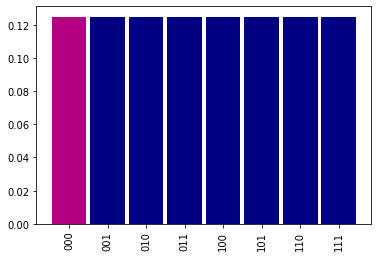

[0.12503296 0.12503296 0.12503296 0.12503296 0.12503296 0.12503296
 0.12503296 0.12503296]


┌───┐               ┌───┐
q_0: ┤ X ├──■─────────■──┤ X ├
     ├───┤  │         │  ├───┤
q_1: ┤ X ├──■─────────■──┤ X ├
     ├───┤  │         │  ├───┤
q_2: ┤ X ├──■─────────■──┤ X ├
     ├───┤  │         │  ├───┤
q_3: ┤ X ├──■─────────■──┤ X ├
     ├───┤  │         │  ├───┤
q_4: ┤ X ├──■─────────■──┤ X ├
     └───┘┌─┴─┐┌───┐┌─┴─┐└───┘
q_5: ─────┤ X ├┤ Z ├┤ X ├─────
     ┌───┐└─┬─┘└───┘└─┬─┘┌───┐
q_6: ┤ X ├──■─────────■──┤ X ├
     ├───┤  │         │  ├───┤
q_7: ┤ X ├──■─────────■──┤ X ├
     └───┘               └───┘

In [126]:
#S0 Gate
S0Circuit = QuantumCircuit(len(set(auxReg+playerReg+countReg+utilReg)))

S0Circuit.x(auxReg+playerReg+[bit for bit in countReg if bit != utilReg[0]])
S0Circuit.mcx(
    control_qubits=auxReg+[bit for bit in countReg if bit != utilReg[0]]+playerReg,
    target_qubit=utilReg
)
S0Circuit.z(utilReg)
S0Circuit.mcx(
    control_qubits=auxReg+[bit for bit in countReg if bit != utilReg[0]]+playerReg,
    target_qubit=utilReg
)
S0Circuit.x(auxReg+playerReg+[bit for bit in countReg if bit != utilReg[0]])
S0Gate = S0Circuit.to_gate(label="S_0")

if debug:
    tempS0Circuit = QuantumCircuit(len(set(auxReg+playerReg+countReg+utilReg)))
    tempS0Circuit.h(playerReg)
    tempS0Circuit += S0Circuit
    assessCircuit(tempS0Circuit, playerReg)

S0Circuit.draw()

#### $S_\psi$ Gate

                                      
q_0: ─────■───────────────────────────
          │                           
q_1: ─────┼──────────■────────────────
          │          │                
q_2: ─────┼──────────┼──────────■─────
     ┌────┴────┐┌────┴────┐┌────┴────┐
q_3: ┤0        ├┤0        ├┤0        ├
     │         ││         ││         │
q_4: ┤1 c(1)+3 ├┤1 c(1)+2 ├┤1 c(1)+1 ├
     │         ││         ││         │
q_5: ┤2        ├┤2        ├┤2        ├
     └─────────┘└─────────┘└─────────┘


C:\Users\iain\AppData\Local\Temp/ipykernel_14648/1799315715.py:32: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  tempSPsiCircuit += SPsiCircuit


{'00000000': (0.5+0j), '00000100': (-0.5+0j), '00010000': (0.5-0j), '00010100': (0.5-0j)}
{'00000000': 0.0, '00000100': 1.0, '00010000': -0.0, '00010100': -0.0}


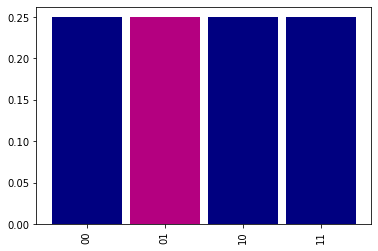

[0.25 0.25 0.25 0.25]


q_0: ──────────────────────────────────────────────────────────────────────────
                                                                               
q_1: ──────────────────────────────────────────────────────────────────────────
     ┌──────────┐     ┌─────────────┐     ┌──────────┐     ┌─────────────┐     
q_2: ┤0         ├─────┤0            ├─────┤0         ├─────┤0            ├─────
     │          │     │             │┌───┐│          │     │             │┌───┐
q_3: ┤1         ├─────┤1            ├┤ X ├┤1         ├─────┤1            ├┤ X ├
     │          │     │             │└───┘│          │     │             │└───┘
q_4: ┤2         ├─────┤2            ├─────┤2         ├─────┤2            ├─────
     │  vOracle │┌───┐│  vOracle^-1 │     │  vOracle │┌───┐│  vOracle^-1 │     
q_5: ┤3         ├┤ Z ├┤3            ├─────┤3         ├┤ Z ├┤3            ├─────
     │          │└───┘│             │     │          │└───┘│             │     
q_6: ┤4         ├─────┤4            ├─────┤4         ├─────┤4            ├─────
     │          │     │             │     │          │     │             │     
q_7: ┤5         ├─────┤5            ├─────┤5         ├─────┤5            ├─────
     └──────────┘     └─────────────┘     └──────────┘     └─────────────┘

In [127]:
#SPsi Gate
voteOracle, _, _, _ = qvg.randomVotingGameGate(
    thresholdBits=numVoteBits,
    playerVal=votingPowers,
)
voteOracle.label = "vOracle"
voteOracleInverse = voteOracle.inverse()
voteOracleInverse.label = "vOracle^-1"

#This is voting game specific 
def vote(circuit):
    circuit.append(
        voteOracle,
        playerReg + countReg,
    )
    circuit.z(utilReg)
    circuit.append(
        voteOracleInverse,
        playerReg + countReg,
    )

SPsiCircuit = QuantumCircuit(len(set(auxReg+playerReg+countReg+utilReg)))

vote(SPsiCircuit)
SPsiCircuit.x(playerReg[targetPlayer])
vote(SPsiCircuit)
SPsiCircuit.x(playerReg[targetPlayer])

if debug:
    tempSPsiCircuit = QuantumCircuit(len(set(auxReg+playerReg+countReg+utilReg)))
    tempSPsiCircuit.h([player for player in playerReg if player != playerReg[targetPlayer]])
    tempSPsiCircuit += SPsiCircuit
    assessCircuit(tempSPsiCircuit, [player for player in playerReg if player != playerReg[targetPlayer]])

SPsiGate = SPsiCircuit.to_gate()
SPsiGate.label = "S_psi"

SPsiCircuit.draw()

#### $Q$ Gate

In [128]:
#Q circuit
QCircuit = QuantumCircuit(len(set(auxReg+playerReg+countReg+utilReg)))

#Phase Gate
phaseCircuit = QuantumCircuit(1)
phaseCircuit.p(np.pi, 0); phaseCircuit.x(0)
phaseCircuit.p(np.pi, 0); phaseCircuit.x(0)
phaseGate = phaseCircuit.to_gate(label="-I")
print(phaseCircuit.draw())

#Main body
QCircuit.append(phaseGate, [0])
QCircuit.append(SPsiGate, auxReg+playerReg+countReg)
QCircuit.append(AInvGate, auxReg+playerReg)
QCircuit.append(S0Gate, auxReg+playerReg+countReg)
QCircuit.append(AGate, auxReg+playerReg)

print(QCircuit.draw())
print(QCircuit.decompose(reps=6).depth())

QGate = QCircuit.to_gate()

   ┌──────┐┌───┐┌──────┐┌───┐
q: ┤ P(π) ├┤ X ├┤ P(π) ├┤ X ├
   └──────┘└───┘└──────┘└───┘
     ┌────┐┌────────┐┌───────┐┌──────┐┌────┐
q_0: ┤ -I ├┤0       ├┤0      ├┤0     ├┤0   ├
     └────┘│        ││       ││      ││    │
q_1: ──────┤1       ├┤1      ├┤1     ├┤1   ├
           │        ││       ││      ││    │
q_2: ──────┤2       ├┤2 A^-1 ├┤2     ├┤2 A ├
           │        ││       ││      ││    │
q_3: ──────┤3       ├┤3      ├┤3     ├┤3   ├
           │  S_psi ││       ││  S_0 ││    │
q_4: ──────┤4       ├┤4      ├┤4     ├┤4   ├
           │        │└───────┘│      │└────┘
q_5: ──────┤5       ├─────────┤5     ├──────
           │        │         │      │      
q_6: ──────┤6       ├─────────┤6     ├──────
           │        │         │      │      
q_7: ──────┤7       ├─────────┤7     ├──────
           └────────┘         └──────┘      
2242


#### $Q$ Circuit Powers

In [129]:
QGatePowers = []

for i in range(amplitudeEstBits):
    QGatePowers.append(
        QGate.repeat(2**i)
    )
    QGatePowers[i].label = f"Q^{2**i}"
    QGatePowers[i] = QGatePowers[i].control()


## Amplitude Estimation Circuit

In [130]:
ampCircuit = QuantumCircuit(len(set(auxReg+playerReg+countReg+utilReg+amplitudeReg)))

#Preparing the amplitude approximation register
ampCircuit.h(amplitudeReg)

#Preparing the other registers
ampCircuit.append(AGate, auxReg + playerReg)

#Running controlled Q's
for i in range(amplitudeEstBits):
    ampCircuit.append(QGatePowers[i], [amplitudeReg[i]]+auxReg+playerReg+countReg)

#Inverse Fourier transform on the amplitude approx register
qftGate = QFT(num_qubits=amplitudeEstBits, inverse=True).to_gate()
qftGate.label = "QFT^-1"
ampCircuit.append(qftGate, amplitudeReg)

print(ampCircuit.draw())

      ┌────┐┌──────┐┌──────┐┌──────┐┌──────┐           
 q_0: ┤0   ├┤0     ├┤0     ├┤0     ├┤0     ├───────────
      │    ││      ││      ││      ││      │           
 q_1: ┤1   ├┤1     ├┤1     ├┤1     ├┤1     ├───────────
      │    ││      ││      ││      ││      │           
 q_2: ┤2 A ├┤2     ├┤2     ├┤2     ├┤2     ├───────────
      │    ││      ││      ││      ││      │           
 q_3: ┤3   ├┤3     ├┤3     ├┤3     ├┤3     ├───────────
      │    ││  Q^1 ││  Q^2 ││  Q^4 ││  Q^8 │           
 q_4: ┤4   ├┤4     ├┤4     ├┤4     ├┤4     ├───────────
      └────┘│      ││      ││      ││      │           
 q_5: ──────┤5     ├┤5     ├┤5     ├┤5     ├───────────
            │      ││      ││      ││      │           
 q_6: ──────┤6     ├┤6     ├┤6     ├┤6     ├───────────
            │      ││      ││      ││      │           
 q_7: ──────┤7     ├┤7     ├┤7     ├┤7     ├───────────
      ┌───┐ └──┬───┘└──┬───┘└──┬───┘└──┬───┘┌─────────┐
 q_8: ┤ H ├────■───────┼───────┼───────┼────┤0  

## Running the Circuit

{'000000000000': (0.0195-0j), '000000000001': (0.0217-0j), '000000000010': (0.0097-0j), '000000000011': (0.0008-0j), '000000000100': (0.0031+0j), '000000000101': (0.0116+0j), '000000000110': (0.0116+0j), '000000000111': (0.0031+0j), '000000010000': (0.0039-0j), '000000010001': (0.0145-0j), '000000010010': (0.0145-0j), '000000010011': (0.0039-0j), '000000010100': (0.0008-0j), '000000010101': (0.0097-0j), '000000010110': (0.0217-0j), '000000010111': (0.0195-0j), '000100000000': (0.0237+0.0087j), '000100000001': (0.0265+0.0098j), '000100000010': (0.0118+0.0044j), '000100000011': (0.0009+0.0003j), '000100000100': (0.0049-0.0043j), '000100000101': (0.0183-0.016j), '000100000110': (0.0183-0.016j), '000100000111': (0.0049-0.0043j), '000100010000': (0.0047+0.0017j), '000100010001': (0.0177+0.0065j), '000100010010': (0.0177+0.0065j), '000100010011': (0.0047+0.0017j), '000100010100': (0.0009+0.0003j), '000100010101': (0.0118+0.0044j), '000100010110': (0.0265+0.0098j), '000100010111': (0.0237+0.0

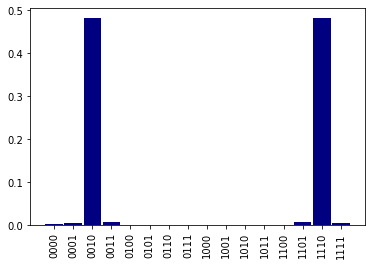

[0.002631   0.00521816 0.48191004 0.00726886 0.00185596 0.00095514
 0.00065566 0.00053846 0.00050562 0.00053846 0.00065566 0.00095514
 0.00185596 0.00726886 0.48191004 0.00521816]


In [131]:
probs = assessCircuit(ampCircuit, amplitudeReg)


#### Post-processing Result 

In [132]:
output = np.sin(
    (np.pi/2**amplitudeEstBits) * np.arange(2**amplitudeEstBits)
)**2
print(output)

estimatedOutput = np.dot(probs, output)
print(estimatedOutput)

[0.         0.03806023 0.14644661 0.30865828 0.5        0.69134172
 0.85355339 0.96193977 1.         0.96193977 0.85355339 0.69134172
 0.5        0.30865828 0.14644661 0.03806023]
0.15187002933738727
